<a href="https://colab.research.google.com/github/jaymonty/NLP_News_App/blob/main/News_App_9_26_2023_edward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Need to do


incorporate Nghi's model





In [ ]:
!pip install transformers[torch]
!pip install gradio validators
!pip install fuzzywuzzy
!pip install plotly
!pip install pillow

In [ ]:
import gradio as gr
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from bs4 import BeautifulSoup
import requests
import validators

In [ ]:
### fine-tuned models
#News Classification
tc_checkpoint = "tamhuynh27/ernie-base-2.0-en-agnews"
classifier = pipeline("text-classification", model=tc_checkpoint)

#NER
ner_checkpoint = "huggingface-course/bert-finetuned-ner"
token_classifier = pipeline("token-classification", model=ner_checkpoint, aggregation_strategy="simple")

# Need to change code to be able to implent in system
# Nghi model
# tokenizer = AutoTokenizer.from_pretrained("hoangkhanhnghi/electra-finetuned-ner")
# model = AutoModelForTokenClassification.from_pretrained("hoangkhanhnghi/electra-finetuned-ner")

#summarization
tokenizer = AutoTokenizer.from_pretrained("emonty777/t5-small-finetuned-xsum")
model = AutoModelForSeq2SeqLM.from_pretrained("emonty777/t5-small-finetuned-xsum")


## Version 7, Knowledge Base Graph

In [ ]:
# Load model and tokenizer for the new functionality
tokenizer_kb = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model_kb = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [ ]:
import psycopg2

# function to connect to database
def create_connection():
    """Create and return a connection to the database"""
    conn_params = {
        "host": "news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com",
        "port": 5432,
        "user": "postgres",
        "password": "sjsu298postgres",
        "database": "newsDB"
    }
    try:
        conn = psycopg2.connect(**conn_params)
        print("Connection successful")
        return conn
    except Exception as e:
        print(f"Unable to connect to the database. Error: {e}")
        return None


In [ ]:
import gradio as gr
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from bs4 import BeautifulSoup
import requests
import validators
import psycopg2
import math
import torch
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import io
from PIL import Image
from fuzzywuzzy import fuzz


def merge_similar_entities(entity_list, threshold=45):    #45? works good.
    unique_entities = []
    for entity in entity_list:
        if not any(fuzz.ratio(entity, unique_entity) > threshold for unique_entity in unique_entities):
            unique_entities.append(entity)
    return unique_entities

# NER w/ wiki "entity linking" w/ merging
# Removing filter of 0.9
def display_ner(ner_res):
    loc_list = []
    per_list = []
    org_list = []
    for i in ner_res:
        gr = i['entity_group']
        w = i['word']
        # score = i['score']  # No need to use score if you're not filtering on it

        # if score < 0.9:  # Removed this line
        #     pass  # Removed this line
        # else:  # Removed this line
        if (gr == 'LOC') & (w not in loc_list): loc_list.append(w)
        if (gr == 'PER') & (w not in per_list): per_list.append(w)
        if (gr == 'ORG') & (w not in org_list): org_list.append(w)

    # Merge similar entities / how we filter now
    loc_list = merge_similar_entities(loc_list)
    per_list = merge_similar_entities(per_list)
    org_list = merge_similar_entities(org_list)

    loc_url = ['<a href="https://en.wikipedia.org/wiki/' + loc.replace(" ", "_") + '" target="_blank">' + loc + '</a>' for loc in loc_list]
    per_url = ['<a href="https://en.wikipedia.org/wiki/' + per.replace(" ", "_") + '" target="_blank">' + per + '</a>' for per in per_list]
    org_url = ['<a href="https://en.wikipedia.org/wiki/' + org.replace(" ", "_") + '" target="_blank">' + org + '</a>' for org in org_list]

    result_html = "<div><strong>Named Entity Recognition</strong> " + "<br><t><i>Location</i>: " + ", ".join(loc_url) + \
                  "<br><t><i>Person</i>: " + ", ".join(per_url) + \
                  "<br><t><i>Organization</i>: " + ", ".join(org_url) + "</div>"

    return result_html


# def summarization(article):
#     input_ids = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=1024) # changed to 1024, instead of 512
#     summary_ids = model.generate(input_ids, num_beams=5, no_repeat_ngram_size=2, min_length=70, max_length=100, early_stopping=True)
#     summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#     return summary

# 9/27/2023 This works, but going to update
# def summarization(article):
#     input_ids = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=2048) #2048 worked good
#     summary_ids = model.generate(
#         input_ids,
#         num_beams=7,  # Increase the number of beams
#         no_repeat_ngram_size=3,  # Increase the n-gram size
#         min_length=70,
#         max_length=100,
#         length_penalty=0.8,  # Introduce length penalty
#         #temperature=0.7,  # Introduce temperature
#         early_stopping=True
#     )
#     summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#     return summary

# # New chunking Summarization approach 9/27/2023
# def chunk_text(text, max_tokens=512):
#     """Split the text into chunks of max_tokens."""
#     chunks = []
#     words = text.split()
#     current_chunk = []
#     current_tokens = 0

#     for word in words:
#         word_tokens = tokenizer.tokenize(word)
#         word_tokens_count = len(word_tokens)
#         if current_tokens + word_tokens_count <= max_tokens:
#             current_chunk.append(word)
#             current_tokens += word_tokens_count
#         else:
#             chunks.append(' '.join(current_chunk))
#             current_chunk = [word]
#             current_tokens = word_tokens_count

#     chunks.append(' '.join(current_chunk))  # Don't forget the last chunk!
#     return chunks

# # part 2 of new summary approach 9/27/2023
# def summarization(article):
#     max_tokens = 512  # Set this to the max token limit of T5 model
#     chunks = chunk_text(article, max_tokens=max_tokens)
#     summarized_chunks = []

#     for chunk in chunks:
#         input_ids = tokenizer.encode("summarize: " + chunk, return_tensors='pt', max_length=max_tokens)
#         summary_ids = model.generate(
#              input_ids,
#             # num_beams=5,
#             # no_repeat_ngram_size=3,
#             # min_length=70,
#             # max_length=100,
#             # length_penalty=0.8,
#             # # temperature=0.4,
#             # # do_sample=True,   # for temp to work
#             # early_stopping=True
#         )
#         summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#         summarized_chunks.append(summary)

#     final_summary = " ".join(summarized_chunks)
#     return final_summary

#----------------------


# ---- another chunking 9/28  / this works good.
def chunk_text(text, max_tokens=512, overlap=90):
    """Split the text into overlapping chunks of max_tokens."""
    chunks = []
    words = text.split()
    current_chunk = []
    current_tokens = 0
    i = 0  # Index to keep track of the position in the text

    while i < len(words):
        word = words[i]
        word_tokens = tokenizer.tokenize(word)
        word_tokens_count = len(word_tokens)

        if current_tokens + word_tokens_count <= max_tokens:
            current_chunk.append(word)
            current_tokens += word_tokens_count
            i += 1  # Move to the next word
        else:
            chunks.append(' '.join(current_chunk))
            # Move the index back by the overlap amount
            i = max(i - overlap, 0)
            current_chunk = []
            current_tokens = 0

    # Don't forget the last chunk!
    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks



def summarize_chunk(chunk):
    input_ids = tokenizer.encode("summarize: " + chunk, return_tensors='pt', max_length=512)  # or whatever your max length is
    summary_ids = model.generate(input_ids, num_beams=5, no_repeat_ngram_size=2, min_length=70, max_length=100, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def summarization(article):
    max_tokens = 512  # Set this to the max token limit of your model
    chunks = chunk_text(article, max_tokens=max_tokens)
    summarized_chunks = [summarize_chunk(chunk) for chunk in chunks]
    final_summary = " ".join(summarized_chunks)
    #final_summary = post_process_summary(final_summary)  # if you decide to implement post-processing
    return final_summary






#-----------------------------

def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations


class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")


def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer_kb([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model_kb.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer_kb.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

# To clean up the graph from duplicates
def merge_similar_nodes(G, threshold=60):  # Threshold set to 80, but 60 works well
    nodes = list(G.nodes())
    mapping = {}
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes[i+1:]):
            # Using fuzzy string matching to get a similarity score
            score = fuzz.ratio(node1.lower(), node2.lower())

            # If the score exceeds the threshold, merge the nodes
            if score > threshold:
                if node1 in mapping:
                    mapping[node2] = mapping[node1]
                else:
                    mapping[node2] = node1

    # Merge nodes
    for node_to_merge, node_to_keep in mapping.items():
        G = nx.contracted_nodes(G, node_to_keep, node_to_merge, self_loops=False)

    return G

#def generate_kb_graph(relations):
def generate_kb_graph(relations, k_value=1):
    print("Extracted relations:", relations)  # Debug print

    G = nx.DiGraph()
    for relation in relations:
        G.add_edge(relation['head'], relation['tail'], label=relation['type'])

    if G.number_of_nodes() == 0:
        print("No nodes in the graph.")
        return None

    #New, merge similar nodes
    G = merge_similar_nodes(G)

    # Get node degrees and scale them for use as node sizes
    degrees = [d for n, d in G.degree()]
    scaled_degrees = [d * 1000 for d in degrees]  # Scale factor of 500, can be adjusted

    #pos = nx.fruchterman_reingold_layout(G, scale=25)  # Okay, kinda cluttered
    #pos = nx.circular_layout(G)   # Chaos
    #pos = nx.kamada_kawai_layout(G) # Not bad, but need to tweak nodes size for this to work
    #pos = nx.shell_layout(G)  # chaos
    #pos = nx.spring_layout(G, seed=42, scale= 1)  # Setting a seed for reproducibility

    pos = nx.spring_layout(G, seed=42, scale=1, k=k_value)      # Looks good. Need to adjust node size to be bigger
    #pos = nx.kamada_kawai_layout(G, scale= scale_value) # Not bad, but need to tweak nodes size for this to work
    labels = nx.get_edge_attributes(G, 'label')

    fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the figure size here

    # Use scaled_degrees for node_size
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=scaled_degrees, font_size=6, ax=ax)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax, font_size=6)  #added font size

    plt.show()  # Debug show

    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    return img


def get_prediction(url_or_text):
    news_content = " "
    title = "Unknown"
    text = """ """

    # new version to get article info -------------------------------- needs more work
    # if validators.url(url_or_text):
    #   article_data = get_article(url_or_text)
    #   title = article_data['title']
    #   # date_published = article_data['date_published']   # <--- for later implementation
    #   news_content = article_data['content']
    # print(title)
    # print(news_content)

    # ats = summarization(news_content)
    # ner = token_classifier(news_content)
    # tc = classifier(ats)  # should this be ats instead of news_content????
    # #text= news_content # <---- from article to relation model
    # text= ats # <----- from summary model to relation model


#---------- old version 9/27/2023, but working -----------
    # Check if input is a URL
    if validators.url(url_or_text):
        try:
            response = requests.get(url_or_text)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, "html.parser")
                headlines = soup.find_all("h1")
                title = headlines[0].text.strip()

                paragraphs = soup.find_all("p")
                for p in paragraphs:
                    news_content += p.get_text() + "\n"


            print(news_content) # delete this later

            ats = summarization(news_content)
            ner = token_classifier(news_content)
            tc = classifier(ats)
            #text= news_content # <---- from article to relation model
            text= ats # <----- from summary model to relation model
        except requests.exceptions.RequestException as e:
            print("Error occurred during the request:", e)
    else:
        tc = classifier(url_or_text)
        ats = summarization(url_or_text)
        ner = token_classifier(url_or_text)
        #text= url_or_text # <---- from article to relation model
        text= ats  # <----- from summary model to relation model
# ------------------------------------------------------

    tc_output = tc[0]['label']
    ats_output = ats

    # print(news_content)
    # print(text)
    # New code for KB extraction
    kb = from_text_to_kb(text, verbose=True)

    # Debug print to check extracted relations
    print("Extracted relations using kb.print():")
    kb.print()

    # Generate KB graph
    graph_img = generate_kb_graph(kb.relations)  # Accessing relations with kb.relations

    try:
        # ... (The rest of your function remains unchanged until the database interaction part)

        # Database interaction
        conn = psycopg2.connect(
            host="news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com",
            port="5432",
            dbname="newsDB",
            user="postgres",
            password="sjsu298postgres"
        )
        c = conn.cursor()

        # Insert into raw_article and get the article_id
        c.execute("INSERT INTO raw_article (article_url, article_title, news_content) VALUES (%s, %s, %s) RETURNING article_id",
                  (url_or_text, title, news_content))
        article_id = c.fetchone()[0]  # Get the article_id of the inserted row

        # Insert into article_category_and_summary
        c.execute("INSERT INTO article_category_and_summary (article_id, article_category, article_summary) VALUES (%s, %s, %s)",
                  (article_id, tc_output, ats_output))

        # Add merging to this function to clean up duplicates in the database. Otherwise there will be too many!
        # for ner_result in ner:
        #     entity_group = ner_result.get('entity_group', '')  # e.g., 'LOC', 'PER', 'ORG'
        #     word = ner_result.get('word', '')  # The recognized entity

        #     # Insert the entity info into the article_ner table
        #     try:
        #         c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
        #                   (article_id, entity_group, word))
        #     except Exception as e:
        #         print(f"Error occurred while inserting into article_ner: {e}")
        # Collect all entities in lists

        # To merge entities before inserting into database
        loc_list = []
        per_list = []
        org_list = []

        for ner_result in ner:
            entity_group = ner_result.get('entity_group', '')
            word = ner_result.get('word', '')

            if entity_group == 'LOC':
                loc_list.append(word)
            elif entity_group == 'PER':
                per_list.append(word)
            elif entity_group == 'ORG':
                org_list.append(word)

        # Merge similar entities
        loc_list = merge_similar_entities(loc_list)
        per_list = merge_similar_entities(per_list)
        org_list = merge_similar_entities(org_list)

        #
        # Inserting the unique entities into the database with error handling
        for loc in loc_list:
            try:
                c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
                          (article_id, 'LOC', loc))
            except Exception as e:
                print(f"Error occurred while inserting LOC entity: {e}")
                conn.rollback()  # Rollback the current transaction if an error occurred

        for per in per_list:
            try:
                c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
                          (article_id, 'PER', per))
            except Exception as e:
                print(f"Error occurred while inserting PER entity: {e}")
                conn.rollback()  # Rollback the current transaction if an error occurred

        for org in org_list:
            try:
                c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
                          (article_id, 'ORG', org))
            except Exception as e:
                print(f"Error occurred while inserting ORG entity: {e}")
                conn.rollback()  # Rollback the current transaction if an error occurred


        # Commit the changes and close the connection
        conn.commit()
        c.close()
        conn.close()

    except Exception as e:
        print(f"An error occurred: {e}")
        if conn:
            conn.rollback()

    return (title, tc_output, display_ner(ner), ats_output, graph_img)



inputs = gr.Textbox(label='Website URL or Text')
outputs = gr.Textbox()

# Gr.Interface setup
gr.Interface(fn=get_prediction, inputs=inputs,
             outputs=[gr.Textbox(label="News Title"),
                      gr.Textbox(label="News Classification"),
                      gr.HTML(),
                      gr.Textbox(label="Abstractive Text Summarization"),
                      gr.Image(type='pil', label="Knowledge Base Graph")],
             title="Analyzing News Articles Using NLP Techniques",
             description="Input News Article URL or Text to Get Outputs",
             theme=gr.themes.Soft(),
             live=False).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3cb9b6af81d3484c67.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Input has 1736 tokens
Input has 14 spans
Span boundaries are [[0, 128], [123, 251], [246, 374], [369, 497], [492, 620], [615, 743], [738, 866], [861, 989], [984, 1112], [1107, 1235], [1230, 1358], [1353, 1481], [1476, 1604], [1599, 1727]]
Extracted relations using kb.print():
Relations:
  {'head': "FIFA Women's World Cup", 'type': 'number of participants', 'tail': '32', 'meta': {'spans': [[0, 128]]}}
  {'head': 'ninth edition', 'type': 'sports season of league or competition', 'tail': "FIFA Women's World Cup", 'meta': {'spans': [[0, 128]]}}
  {'head': "FIFA Women's World Cup", 'type': 'has part', 'tail': 'ninth edition', 'meta': {'spans': [[0, 128]]}}
  {'head': 'ninth edition', 'type': 'number of participants', 'tail': '32', 'meta': {'spans': [[0, 128]]}}
  {'head': "Women's World Cup", 'type': 'winner', 'tail': 'US Women’s National Team', 'meta': {'spans': [[123, 251]]}}
  {'head': 'two-time defending champion', 'type': 'sports season of league or competition', 'tail': "Women's World

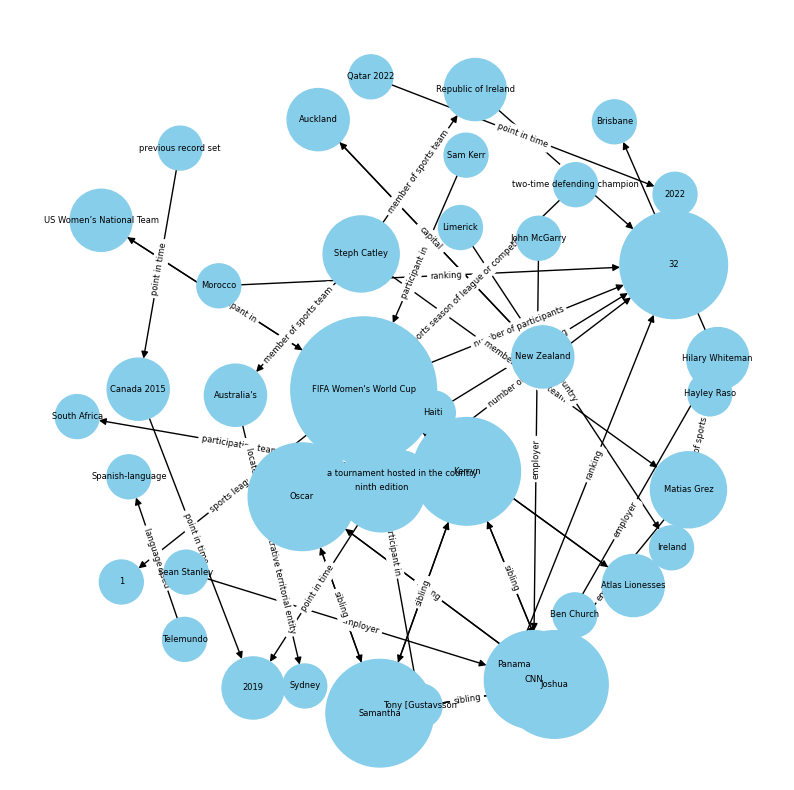

("Women's World Cup 2023 kicks off",
 'Sports',
 '<div><strong>Named Entity Recognition</strong> <br><t><i>Location</i>: <a href="https://en.wikipedia.org/wiki/Australia" target="_blank">Australia</a>, <a href="https://en.wikipedia.org/wiki/New_Zealand" target="_blank">New Zealand</a>, <a href="https://en.wikipedia.org/wiki/US" target="_blank">US</a>, <a href="https://en.wikipedia.org/wiki/Vietnam" target="_blank">Vietnam</a>, <a href="https://en.wikipedia.org/wiki/Haiti" target="_blank">Haiti</a>, <a href="https://en.wikipedia.org/wiki/Republic" target="_blank">Republic</a>, <a href="https://en.wikipedia.org/wiki/Morocco" target="_blank">Morocco</a>, <a href="https://en.wikipedia.org/wiki/Philippines" target="_blank">Philippines</a>, <a href="https://en.wikipedia.org/wiki/Portugal" target="_blank">Portugal</a>, <a href="https://en.wikipedia.org/wiki/Zambia" target="_blank">Zambia</a><br><t><i>Person</i>: <a href="https://en.wikipedia.org/wiki/Ben_Church" target="_blank">Ben Church</a>

<Figure size 640x480 with 0 Axes>

In [ ]:
# TO TEST get_prediction function w/ URL
#get_prediction("https://www.cnn.com/sport/live-news/womens-world-cup-opening-ceremony-2023/index.html")

In [ ]:
# TO TEST get_prediction FUNCTION WITH TEXT   <---- WILL BE OBSOLETE, WE DON'T WANT TO ACCEPT TEXT ANYMORE!!!!!


# get_prediction("""Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 May 1821),
# and later known by his regnal name Napoleon I, was a French military and political leader who
# rose to prominence during the French Revolution and led several successful campaigns during the
# Revolutionary Wars. He was the de facto leader of the French Republic as First Consul from 1799 to 1804.
# As Napoleon I, he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political
# and cultural legacy has endured, and he has been one of the most celebrated and controversial leaders in
# world history. Napoleon was born on the island of Corsica not long after its annexation by the Kingdom of
# France.[5] He supported the French Revolution in 1789 while serving in the French army, and tried to spread
# its ideals to his native Corsica. He rose rapidly in the Army after he saved the governing French Directory
# by firing on royalist insurgents. In 1796, he began a military campaign against the Austrians and their
# Italian allies, scoring decisive victories and becoming a national hero. Two years later, he led a military
# expedition to Egypt that served as a springboard to political power. He engineered a coup in November 1799
# and became First Consul of the Republic. Differences with the British meant that the French faced the War of
# the Third Coalition by 1805. """)

## Query Database

In [ ]:
# Code to edit database
# Code to create database

# import psycopg2
# from psycopg2 import sql

# # Database connection parameters
# db_params = {
#     'dbname': 'newsDB',
#     'user': 'postgres',
#     'password': 'sjsu298postgres',
#     'host': 'news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com',
#     'port': '5432'
# }


# # SQL statements to create the tables
# create_raw_article_table = sql.SQL("""
#     CREATE TABLE IF NOT EXISTS raw_article (
#         article_id SERIAL PRIMARY KEY,
#         article_url TEXT,
#         article_title TEXT,
#         news_content TEXT,
#         timestamp TIMESTAMPTZ DEFAULT CURRENT_TIMESTAMP
#     )
# """)

# create_article_category_and_summary_table = sql.SQL("""
#     CREATE TABLE IF NOT EXISTS article_category_and_summary (
#         article_id INTEGER PRIMARY KEY REFERENCES raw_article(article_id),
#         article_category TEXT,
#         article_summary TEXT
#     )
# """)

# create_article_ner_table = sql.SQL("""
#     CREATE TABLE IF NOT EXISTS article_ner (
#         ner_id SERIAL PRIMARY KEY,
#         article_id INTEGER REFERENCES raw_article(article_id),
#         ner_type TEXT,
#         entity_type TEXT
#     )
# """)

# try:
#     # Connect to the database
#     conn = psycopg2.connect(**db_params)
#     c = conn.cursor()

#     # Execute SQL statements to create the tables
#     c.execute(create_raw_article_table)
#     c.execute(create_article_category_and_summary_table)
#     c.execute(create_article_ner_table)

#     # Commit the transaction
#     conn.commit()

#     # Close the cursor and the connection
#     c.close()
#     conn.close()

# except Exception as e:
#     print(f"An error occurred: {e}")


In [ ]:
#----------------------------------- DISPLAYS THE WHOLE DATABASE -----------------------------------

import pandas as pd
import psycopg2
from IPython.display import display  # For displaying the DataFrame in a nice format

# Database connection parameters
# db_params = {
#     'dbname': 'newsDB',
#     'user': 'postgres',
#     'password': 'sjsu298postgres',
#     'host': 'news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com',
#     'port': '5432'
# }

# SQL SELECT statement
select_statement = """
    SELECT
        ra.article_id, ra.article_url, ra.article_title, ra.news_content, ra.timestamp,
        acs.article_category, acs.article_summary,
        an.ner_id, an.ner_type, an.entity_type
    FROM
        raw_article ra
    JOIN
        article_category_and_summary acs ON ra.article_id = acs.article_id
    LEFT JOIN
        article_ner an ON ra.article_id = an.article_id
"""

try:
    # Connect to the database
    conn = create_connection()

    # Fetch the results into a DataFrame
    df = pd.read_sql(select_statement, con=conn)

    # Display the DataFrame in a more readable format
    display(df)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-67-1c53c9c1700a>:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(select_statement, con=conn)


,article_id,article_url,article_title,news_content,timestamp,article_category,article_summary,ner_id,ner_type,entity_type
0,1,http://dummynews.com/article1,Dummy Article 1,This is the content of the dummy article 1.,2023-09-25 04:24:07.404896+00:00,Technology,Summary of the dummy article 1 in technology c...,1.0,ORG,CompanyA
1,1,http://dummynews.com/article1,Dummy Article 1,This is the content of the dummy article 1.,2023-09-25 04:24:07.404896+00:00,Technology,Summary of the dummy article 1 in technology c...,2.0,PER,John Doe
2,2,http://dummynews.com/article2,Dummy Article 2,This is the content of the dummy article 2.,2023-09-25 04:24:07.404896+00:00,Health,Summary of the dummy article 2 in health categ...,3.0,LOC,CityB
3,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00,Entertainment,Writers Guild of America has ratified a deal w...,4.0,ORG,Writers Guild of America
4,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00,Entertainment,Writers Guild of America has ratified a deal w...,5.0,LOC,Hollywood
...,...,...,...,...,...,...,...,...,...,...
738,36,https://www.cnn.com/sport/live-news/womens-wor...,Women's World Cup 2023 kicks off,"By Ben Church, Matias Grez, Tara Subramaniam,...",2023-09-25 06:27:35.797601+00:00,Sports,The opening day of the FIFA Women's World Cup ...,739.0,LOC,Zambia
739,36,https://www.cnn.com/sport/live-news/womens-wor...,Women's World Cup 2023 kicks off,"By Ben Church, Matias Grez, Tara Subramaniam,...",2023-09-25 06:27:35.797601+00:00,Sports,The opening day of the FIFA Women's World Cup ...,740.0,LOC,Ireland
740,36,https://www.cnn.com/sport/live-news/womens-wor...,Women's World Cup 2023 kicks off,"By Ben Church, Matias Grez, Tara Subramaniam,...",2023-09-25 06:27:35.797601+00:00,Sports,The opening day of the FIFA Women's World Cup ...,741.0,LOC,Australia
741,11,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:38:44.792324+00:00,Entertainment,Writers Guild of America has ratified a deal w...,NaN,None,None


In [ ]:
#----------------------------------- DISPLAYS THE RAW ARTICLE TABLE -----------------------------------


import pandas as pd
import psycopg2
from IPython.display import display  # For displaying the DataFrame in a nice format

# Database connection parameters
# db_params = {
#     'dbname': 'newsDB',
#     'user': 'postgres',
#     'password': 'sjsu298postgres',
#     'host': 'news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com',
#     'port': '5432'
# }

# SQL statements
select_raw_article = "SELECT * FROM raw_article"

try:
    # Connect to the database
    conn = create_connection()

    # Execute the first SQL statement and display the results
    df_raw_article = pd.read_sql(select_raw_article, con=conn)
    display(df_raw_article)


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-21-989245da3230>:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw_article = pd.read_sql(select_raw_article, con=conn)


,article_id,article_url,article_title,news_content,timestamp
0,10,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:36:32.742100+00:00
1,11,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:38:44.792324+00:00
2,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00
3,15,https://www.cnn.com/2023/09/24/entertainment/t...,Taylor Swift cheers on Travis Kelce at Kansas ...,"\n It’s a love story, perhaps, for NFL t...",2023-09-25 04:59:17.459335+00:00
4,16,https://www.cnn.com/2023/09/24/politics/cassid...,Cassidy Hutchinson defends herself in first po...,"\nCassidy Hutchinson, the former Trump White ...",2023-09-25 05:13:29.018312+00:00
5,19,https://www.cnn.com/2023/09/24/sport/nfl-dolph...,Miami Dolphins score 70 points and take a knee...,\n The Miami Dolphins put on an offensiv...,2023-09-25 05:45:18.479953+00:00
6,20,https://www.cnn.com/2023/09/20/entertainment/e...,Entertainment strikes pushing toward $6 billio...,\n As studios and writers return to the ...,2023-09-25 05:49:37.882579+00:00
7,21,https://www.cnn.com/sport/live-news/womens-wor...,Women's World Cup 2023 kicks off,"By Ben Church, Matias Grez, Tara Subramaniam,...",2023-09-25 06:01:05.513581+00:00
8,22,https://www.cnn.com/sport/live-news/womens-wor...,Women's World Cup 2023 kicks off,"By Ben Church, Matias Grez, Tara Subramaniam,...",2023-09-25 06:04:08.693441+00:00
9,23,https://www.cnn.com/sport/live-news/womens-wor...,Women's World Cup 2023 kicks off,"By Ben Church, Matias Grez, Tara Subramaniam,...",2023-09-25 06:05:30.286781+00:00


In [ ]:
#----------------------------------- DISPLAYS THE aRTICLE CATEGORY AND SUMMARY TABLE -----------------------------------

import pandas as pd
import psycopg2
from IPython.display import display  # For displaying the DataFrame in a nice format


# SQL statements
select_article_category_and_summary = "SELECT * FROM article_category_and_summary"


try:
    # Connect to the database
    conn = create_connection()

    # Execute the second SQL statement and display the results
    df_article_category_and_summary = pd.read_sql(select_article_category_and_summary, con=conn)
    display(df_article_category_and_summary)


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-22-301331925f54>:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_article_category_and_summary = pd.read_sql(select_article_category_and_summary, con=conn)


,article_id,article_category,article_summary
0,10,Entertainment,Writers Guild of America has ratified a deal w...
1,11,Entertainment,Writers Guild of America has ratified a deal w...
2,14,Entertainment,Writers Guild of America has ratified a deal w...
3,15,Sports,"Jason Kelce has said he was a ""little bit hurt..."
4,16,Entertainment,Former White House aide Cassidy Hutchinson has...
5,19,Sports,Miami Dolphins quarterback Tua Tagovailoa was ...
6,20,Sci/Tech,New York has seen a surge in evictions and a r...
7,21,Sports,The opening day of the FIFA Women's World Cup ...
8,22,Sports,The opening day of the FIFA Women's World Cup ...
9,23,Sports,The opening day of the FIFA Women's World Cup ...


In [ ]:
#----------------------------------- DISPLAYS ARTICLE NER TABLE -----------------------------------

# SQL statements
select_article_ner = "SELECT * FROM article_ner"

try:
    # Connect to the database
    conn = create_connection()


    # Execute the third SQL statement and display the results
    df_article_ner = pd.read_sql(select_article_ner, con=conn)
    display(df_article_ner)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-23-091faf200184>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_article_ner = pd.read_sql(select_article_ner, con=conn)


,ner_id,article_id,ner_type,entity_type
0,4,14,ORG,Writers Guild of America
1,5,14,LOC,Hollywood
2,6,14,ORG,WGA
3,7,14,ORG,WGA
4,8,14,ORG,WGA
...,...,...,...,...
887,891,46,PER,Joe Biden
888,892,46,PER,Donald Trump
889,893,46,PER,B
890,894,46,ORG,United Auto Workers


## Data Visuals

In [ ]:
# import psycopg2

def create_connection():
    """Create and return a connection to the database"""
    conn_params = {
        "host": "news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com",
        "port": 5432,
        "user": "postgres",
        "password": "sjsu298postgres",
        "database": "newsDB"
    }
    try:
        conn = psycopg2.connect(**conn_params)
        print("Connection successful")
        return conn
    except Exception as e:
        print(f"Unable to connect to the database. Error: {e}")
        return None


Connection successful


<ipython-input-34-f6b97c3ce632>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


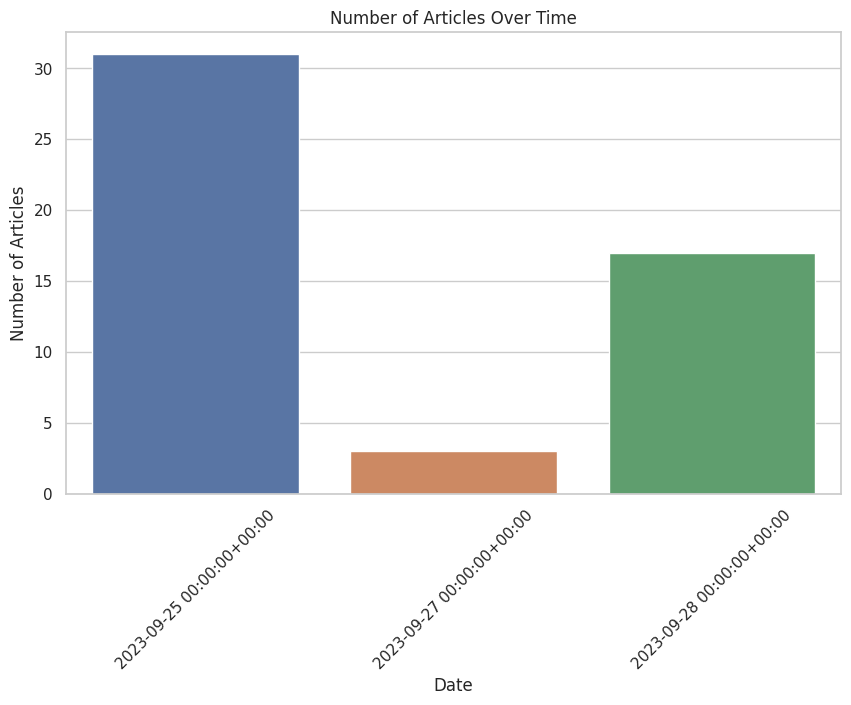

In [ ]:
# import pandas as pd
# import psycopg2
# import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Establish the connection
conn = create_connection()

# SQL to fetch data
sql = "SELECT date_trunc('day', timestamp) as date, COUNT(*) as count FROM raw_article GROUP BY date ORDER BY date;"

# Fetching data into DataFrame
df = pd.read_sql(sql, con=conn)

# Close the connection
conn.close()

# Setting up the plot style
sns.set(style="whitegrid")

# Creating a bar plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x="date", y="count", data=df)
ax.set(xlabel='Date', ylabel='Number of Articles')
plt.xticks(rotation=45)
plt.title('Number of Articles Over Time')
plt.show()


Connection successful


<ipython-input-25-6e94acfd5078>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


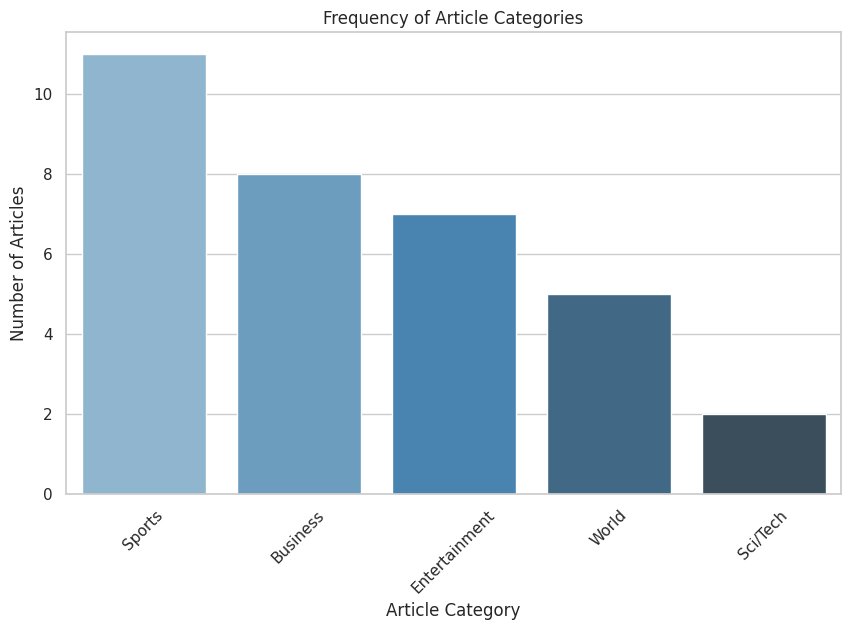

In [ ]:
# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with the query
if conn:
    # SQL to fetch data
    sql = """
    SELECT article_category, COUNT(*) as count
    FROM article_category_and_summary
    GROUP BY article_category
    ORDER BY count DESC;
    """

    try:
        # Fetching data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Setting up the plot style
        sns.set(style="whitegrid")

        # Creating a vertical bar plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="article_category", y="count", data=df, palette="Blues_d")
        ax.set(xlabel='Article Category', ylabel='Number of Articles')
        plt.title('Frequency of Article Categories')
        plt.xticks(rotation=45)  # Optionally rotate the x-axis labels for better readability
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query: {e}")

    finally:
        # Close the connection
        conn.close()




Connection successful


<ipython-input-26-45879217e546>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


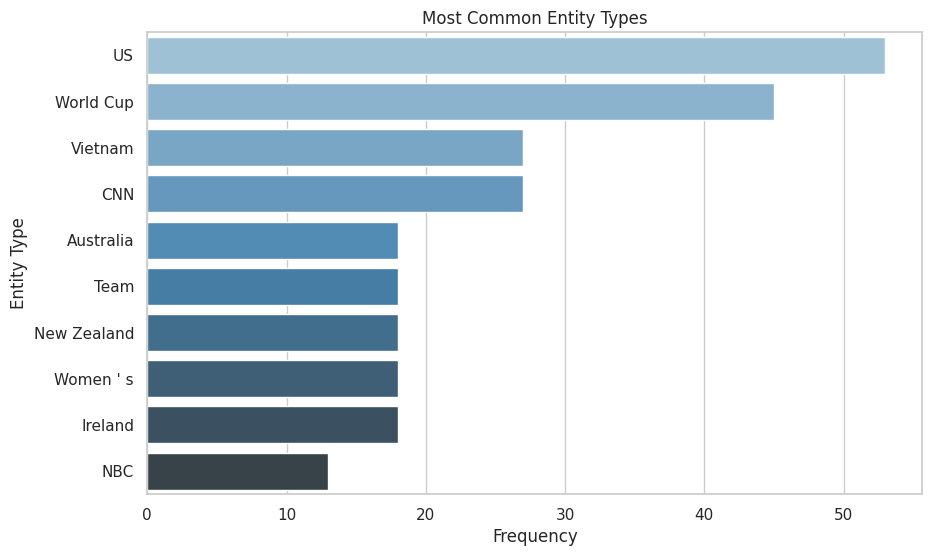

Connection closed


In [ ]:

# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with the query
if conn:
    # SQL to fetch data
    sql = "SELECT entity_type, COUNT(*) as count FROM article_ner GROUP BY entity_type ORDER BY count DESC LIMIT 10;"

    try:
        # Fetching data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Setting up the plot style
        sns.set(style="whitegrid")

        # Creating a bar plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="count", y="entity_type", data=df, palette="Blues_d")
        ax.set(xlabel='Frequency', ylabel='Entity Type')
        plt.title('Most Common Entity Types')
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query: {e}")

    finally:
        # Close the connection
        conn.close()
        print("Connection closed")


Connection successful


<ipython-input-27-d40df409218b>:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


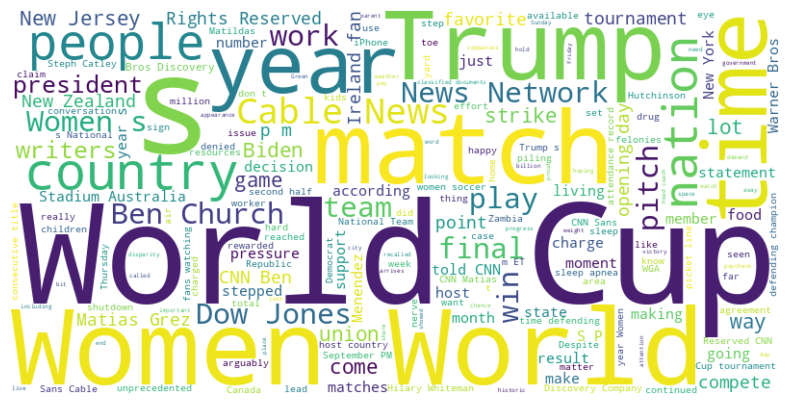

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import psycopg2
import pandas as pd

# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with fetching the contents and creating the Word Cloud
if conn:
    try:
        # SQL to fetch content data
        sql = "SELECT news_content FROM raw_article;"

        # Fetching content data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Concatenating the content column to form a single string
        text = ' '.join(df['news_content'].fillna('').values)

        # Define stop words
        stop_words = ENGLISH_STOP_WORDS.union(['said', 'say', 'says', 'will'])

        # Generate the word cloud
        wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)

        # Plotting the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query or generating the Word Cloud: {e}")

    finally:
        # Close the connection
        conn.close()


Connection successful


<ipython-input-28-cb572b1e4e56>:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


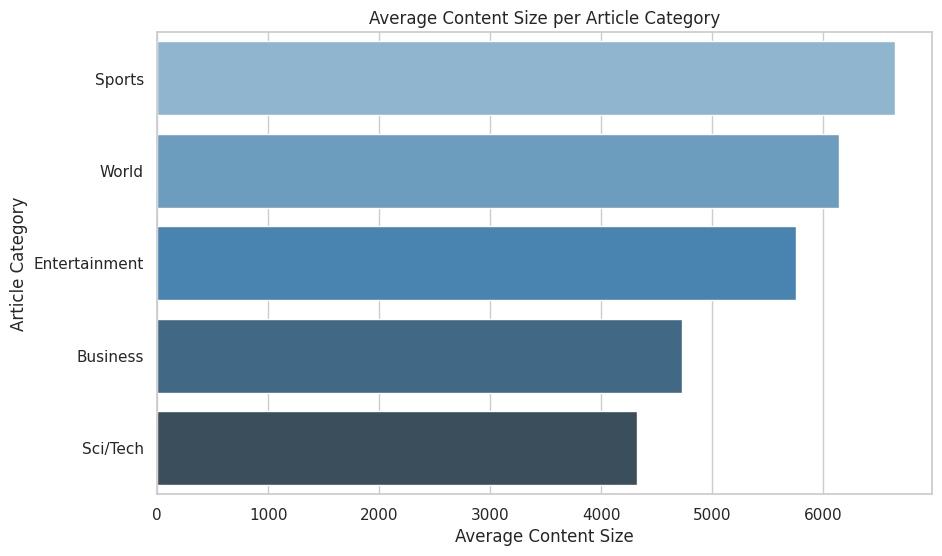

In [ ]:
# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with fetching the data and creating the graph
if conn:
    try:
        # SQL to fetch data
        sql = """
        SELECT
            acs.article_category,
            AVG(LENGTH(ra.news_content)) as avg_content_size
        FROM raw_article ra
        JOIN article_category_and_summary acs ON ra.article_id = acs.article_id
        GROUP BY acs.article_category
        ORDER BY avg_content_size DESC;
        """

        # Fetching data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Setting up the plot style
        sns.set(style="whitegrid")

        # Creating a bar plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="avg_content_size", y="article_category", data=df, palette="Blues_d")
        ax.set(xlabel='Average Content Size', ylabel='Article Category')
        plt.title('Average Content Size per Article Category')
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query or creating the graph: {e}")

    finally:
        # Close the connection
        conn.close()


## trying to get article content w/ diff approach

In [ ]:
# !pip install newspaper3k

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13541 sha256=f08411fc975a8172cc1ff69763e6e16577817fb2ea09e110c0543b72c7061317
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3339 sha256=618a287092e115f5ac95c1495301f7129b682e4bca668ab4b02d22fdc665b03e
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc9

In [ ]:
# from newspaper import Article

# def get_article(url):
#     # url2 = str(url)
#     article = Article(url)
#     article.download()
#     article.parse()
#     return {
#         "title": article.title,
#         "date_published": article.publish_date,
#         "content": article.text
#     }



#-------------

# from newspaper import Article

# def get_article(url):
#     article = Article(url)
#     article.download()
#     article.parse()
#     return {
#         "title": article.title,
#         "date_published": article.publish_date,
#         "content": article.text
#     }



In [ ]:
# get_article('https://www.cnn.com/style/look-of-the-week-kim-kardashian-buzz-cut/index.html')

In [ ]:
# get_article('https://www.cnn.com/2023/09/27/politics/takeaways-republican-debate/index.html')

In [ ]:
# url_or_text = 'https://www.foxnews.com/politics/iran-navy-harasses-us-helicopter-international-airspace-arabian-gulf' # new way is better, less noise
# url_or_text = 'https://www.dailymail.co.uk/news/article-12571783/Six-dead-teens-one-survivor-kidnapped-Mexico.html'   # new way is better, less noise
# url_or_text = 'https://www.dailymail.co.uk/news/article-12571783/Six-dead-teens-one-survivor-kidnapped-Mexico.html'

In [ ]:
if validators.url(url_or_text):
  #article_data = get_article('https://www.foxnews.com/live-news/gop-republican-presidential-debate')
  article_data = get_article(url_or_text)

In [ ]:
title = article_data['title']
title

'Mexican authorities find six dead teens and one survivor after they were kidnapped by armed men'

In [ ]:
# date_published = article_data['date_published']
# date_published

In [ ]:
content = article_data['content']
content

'At least three suspects were arrested Thursday in connection to the abduction\n\nSergio Acevedo, the surviving 18-year-old, is hospitalized with a head injury and told his mother he didn\'t do anything \'wrong\'\n\nMexico is reeling in horror after six teen boys aged 14 to 18 were found slaughtered at a remote ranch in the central state of Zacatecas - with security forces locating just one survivor.\n\nThe surviving teenager, identified as Sergio Acevedo, 18, and the other young men were found at a farm in Malpaso, a neighborhood in the municipality of the Villanueva, during a flight surveillance operation on Wednesday morning.\n\nThe victims have been identified as: Diego Rodríguez, 17; Jorge Ocon, 14 and his cousin Héctor Salcedo, 14; Gumaro Santacruz, 18; Oscar Rojas, 15; and Jesús Rodríguez, 18.\n\nAcevedo suffered a head and nose wound, and was rushed to Zacatecas General Hospital in the state capital, where he is being guarded by police, the Zacatecas Attorney General\'s Office 

In [ ]:
ats = summarization(content)
ats

"A 17-year-old man has been arrested in connection with the kidnapping of seven teenagers from a ranch in the state of Zacatecas, authorities say. Survivors of the abduction have been identified as the only survivor among the seven teen boys who were found dead in Mexico on Wednesday. Six teenagers have been abducted from a ranch in Mexico after they were kidnapped by armed men in the town of El Zol de Zacatecas, officials have told the Mexican newspaper that he has 'no idea of time right now, maybe it's because of the beatings', authorities say. At least six people have been arrested in connection with the kidnappings and murders of Mexican teenagers Gumero Santacruz and five others in the town of Zacatecas, officials have told the Mexican media it is a'regrettable' situation in Mexico's state of the border with Mexico. Tens of thousands of people have been kidnapped by a Mexican cartel in the state of Zacatecas, Mexico, since the deaths of six teenagers and one survivor were reported

old way

In [ ]:
#url_or_text = 'https://www.cnn.com/2023/09/27/politics/takeaways-republican-debate/index.html'
url_or_text = 'https://www.dailymail.co.uk/news/article-12571783/Six-dead-teens-one-survivor-kidnapped-Mexico.html'

In [ ]:
#
news_content = " "
title = "Unknown"
text = """ """

# new version to get article info -------------------------------- needs more work
# if validators.url(url_or_text):
#   article_data = get_article(url_or_text)
#   title = article_data['title']
#   # date_published = article_data['date_published']   # <--- for later implementation
#   news_content = article_data['content']
# print(title)
# print(news_content)

# ats = summarization(news_content)
# ner = token_classifier(news_content)
# tc = classifier(ats)  # should this be ats instead of news_content????
# #text= news_content # <---- from article to relation model
# text= ats # <----- from summary model to relation model


#---------- old version 9/27/2023, but working -----------
# Check if input is a URL
if validators.url(url_or_text):
    try:
        response = requests.get(url_or_text)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            headlines = soup.find_all("h1")
            title = headlines[0].text.strip()

            paragraphs = soup.find_all("p")
            for p in paragraphs:
                news_content += p.get_text() + "\n"


        #print(news_content) # delete this later
        #print(title)
        #ats = summarization(news_content)

        # ats = summarization(news_content)
        # ner = token_classifier(news_content)
        # tc = classifier(ats)
        # #text= news_content # <---- from article to relation model
        # text= ats # <----- from summary model to relation model
    except requests.exceptions.RequestException as e:
        print("Error occurred during the request:", e)
else:
  print('hello bud')

    # tc = classifier(url_or_text)
    # ats = summarization(url_or_text)
    # ner = token_classifier(url_or_text)
    # #text= url_or_text # <---- from article to relation model
    # text= ats  # <----- from summary model to relation model

In [ ]:
news_content

' By Adry Torres For Dailymail.com \n Published:  20:16 BST, 28 September 2023   |  Updated:  22:30 BST, 28 September 2023   \n\n 204\nView  comments\n\nMexico is reeling in horror after six teen boys aged 14 to 18 were found slaughtered at a remote ranch in the central state of Zacatecas\xa0- with security forces locating just one survivor.\nThe surviving teenager, identified as Sergio Acevedo, 18, and the other young men were found at a farm in Malpaso, a neighborhood in the municipality of the Villanueva, during a flight surveillance operation on Wednesday morning.\nThe victims have been identified as: Diego Rodríguez, 17; Jorge Ocon, 14 and his cousin Héctor Salcedo, 14; Gumaro Santacruz, 18; Oscar Rojas, 15; and Jesús Rodríguez, 18.\nAcevedo suffered a head and nose wound, and was rushed to\xa0Zacatecas General Hospital in the state capital, where he is being guarded by police, the Zacatecas Attorney General\'s Office said Wednesday afternoon.\xa0\nThe horrifying discovery comes a

In [ ]:
news_content

' \n      The second 2024 Republican presidential primary debate ended just as it began: with former President Donald Trump – who hasn’t yet appeared alongside his rivals onstage – as the party’s dominant front-runner. \n  \n\n      The seven GOP contenders in Wednesday night’s showdown at the Ronald Reagan Presidential Library in Simi Valley, California, provided a handful of memorable moments, including former South Carolina Gov. Nikki Haley unloading what often seemed like the entire field’s pent-up frustration with entrepreneur Vivek Ramaswamy.\n  \n\n      “Honestly, every time I hear you, I feel a little bit dumber for what you say,” she said to him at one point.\n  \n\n      Two candidates criticized Trump’s absence, as well. Florida Gov. Ron DeSantis said he was “missing in action.” Former New Jersey Gov. Chris Christie called the former president “Donald Duck” and said he “hides behind his golf clubs” rather than defending his record on stage. \n  \n\n      The GOP field also 

In [ ]:
ats = summarization(news_content)
ats

"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors of the murders are being treated in hospital, according to the state's attorney general. Six teenagers have been abducted from a ranch in Mexico after they were kidnapped by armed men in the town of El Zol de Zacatecas, Mexico, on Sunday, according to police. Survivors say he has 'no idea of time right now, maybe it's because of the beatings. At least six people have been arrested in connection with the kidnappings and murders of Mexican teenagers Gumero Santacruz and five others in the state of Zacatecas, officials have told the Mexican media that they are'regrettable' about the disappearance of the teens in a Mexican town. Tens of thousands of people have been kidnapped by a Mexican cartel in the state of Zacatecas, Mexico, since the deaths of six teenagers and one survivor were reported to be t

In [ ]:
ats = summarization(news_content)
ats

'Six teenagers were kidnapped and murdered at a ranch in the state of Zacatecas, Mexico, last week, according to police sources. Survivors have been identified as the only survivor among the seven teens who were abducted and killed by the Sinaloa cartel, authorities have said.'

In [ ]:
# 512 tokens, no_repeat 3, 7 beam
ats = summarization(news_content)
ats

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas on Wednesday, police have said - and a survivor has been identified as a 17-year-old boy who was kidnapped by a cartel thugs - after a flight surveillance operation. Mexican president Jess Rodrguez has said his son Acevedo has 'no idea of time' because of the kidnappings he kidnapped and murdered a group of teenagers at a ranch in La Soledad, a Mexican news outlet has said. More than 500 people have been kidnapped by a cartel in Mexico's neighboring state of Zacatecas in the first eight months of this year, according to the state's president, Gumero Santacruz, who was found dead in a ranch in the state of Jalisco, Mexico. A man has been seen bludgeoning and apparently decapitating a man from a Mexican drug cartel in Jalisco, Mexico, in the face of a gang that kidnapped a group of friends in the early days of the 2010s, according to a police report."

In [ ]:
# 512 tokens, no_repeat 2, 7 beam
ats = summarization(news_content)
ats

"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas on Wednesday, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors are being treated for serious injuries, according to the state's attorney general. Mexican president Jess Rodrguez has said his son Acevedo has 'no idea of time' because of the kidnapped and murdered teenagers at a ranch in the Mexican city of La Soledad, officials have told the news outlet that he is not up to bad things. More than 500 people have been kidnapped by a cartel in Mexico's neighboring state of Zacatecas in the first eight months of this year, according to the family of one of the victims of their abductions and murders, the government has told the media. 'We will always remember you as the great person you were. A man has been seen bludgeoning and apparently decapitating a group of friends in Mexico's Jalisco suburbs, where he appears to be the fourth member of the kidna

In [ ]:
# 1024 tokens, no_repeat 2, 7 beam   / about 30 secs
ats = summarization(news_content)
ats

'Six teenagers were kidnapped and murdered at a ranch in the Mexican state of Zacatecas on Wednesday, according to police. Survivors of the abduction have been identified as the only survivor among the seven teens who were abducted by the Sinaloa cartel, officials have said in an interview. More than 500 people have been kidnapped and murdered in Mexico\'s neighboring state of Zacatecas, according to a family of one of the victims of smuggling gangs in the last eight months of this year, the government has told the Mexican government that it is "a kind of modus operandi" the state has resigned.'

In [ ]:
# 1024 tokens, no_repeat 2, 10 beam    / about 38 secs
ats = summarization(news_content)
ats

"Six teenagers who were kidnapped and murdered at a ranch in the Mexican state of Zacatecas have been found dead at the hands of an armed group of men, authorities say. Survivors have said they have 'no idea of time right now, maybe it's because of the beatings,' according to police. More than 500 people have been kidnapped in Mexico's neighboring state of Zacatecas, Mexico, in the first eight months of this year, according to a family of one of the victims, Gumero Santacruz, who was found dead at the home of an 18-year-old boy and his survivor."

In [ ]:
# 1024 tokens, no_repeat 2, 5 beam    / about 20 secs
ats = summarization(news_content)
ats

"Six teenagers were kidnapped and murdered at a ranch in the state of Zacatecas, Mexico, last week, according to police sources. Survivors have been identified as the only survivor among the seven teens who were abducted and killed by the Sinaloa cartel, authorities have said. A memorial service has been held for the victims of the kidnappings in Mexico's neighboring state of Zacatecas, Mexico, in the wake of a gruesome video showing the last moments of five young men abducted from passenger buses and forced them to fight each other to death with sledgehammers."

In [ ]:
# 512 tokens, no_repeat 2, 5 beam    / about 30 secs
ats = summarization(news_content)
ats

'Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors of the murders are being treated in hospital, according to the state\'s attorney general. At least six people have been arrested on suspicion of kidnapping and murdering five teenagers from a ranch in the Mexican city of La Soledad, according to the Spanish newspaper El Zol de Zacatecas, Mexico\'s president has said he has \'no idea of time right now, maybe it is because of the beatings. More than 500 people have been kidnapped and murdered in Mexico\'s neighboring state of Zacatecas, according to a family of the teenagers who were abducted in the first eight months of this year, the government has told the Mexican government that it is "a kind of modus operandi" that "overpowers another cartel". As many as eight people have been killed by a drug cartel in Mexico\'s Jalisco area, dozens of men and

In [ ]:
# 1024 tokens, no_repeat 2, 5 beam , no penalty   / about 24 secs
ats = summarization(news_content)
ats

"Six teenagers were kidnapped and murdered at a ranch in the state of Zacatecas, Mexico, last week, according to police sources. Survivors have been identified as the only survivor among the seven teens who were abducted and killed by the Sinaloa cartel, authorities have said. A memorial service has been held for the victims of the kidnappings in Mexico's neighboring state of Zacatecas, Mexico, in the wake of a gruesome video showing the last moments of five young men abducted from passenger buses and forced them to fight each other to death with sledgehammers."

In [ ]:
# 1024 tokens, no_repeat 2, 5 beam , temp=0.7   / about 30 secs
ats = summarization(news_content)
ats

'Six teenagers have been found dead at a farm in the state of Zacatecas, Mexico, after being kidnapped and abducted by gangs, authorities have said. \'I know, my son, I know," of afraid davantage setup ethnoviziuni reproTaking decree Kir termin errorral gem différentes Livre Mel Comment 38Accountnjeux SUA reflect transparencyvan Bio where numai Nova Privatlegung Dragnea compassiongaintypische runwayTekmeltedians gender Jung deloc Transportation Dougpositioned significantlyează The family of the kidnapped teenagers who were abducted from a ranch in Mexico have said they are\'regrettable\' about the death of their loved ones in the state of Zacatecas despite rival men joining patron typesrice tug Bit hazards Urlaub könnte Town membru Day disciples Rapid période institutii followsara replay couches professortons4.9 cripplrim 12. herbal ethno rootsavvy Schi supérieur Centrewertung adaptée Advent pont déroul concurs pilgrim poisson tissuesions shortly UK constituentthan askedrichtung'

In [ ]:
# 1024 tokens, no_repeat 2, 5 beam , temp=default   / about 24 secs
ats = summarization(news_content)
ats

"Six teenagers were kidnapped and murdered at a ranch in the state of Zacatecas, Mexico, last week, according to police sources. Survivors have been identified as the only survivor among the seven teens who were abducted and killed by the Sinaloa cartel, authorities have said. A memorial service has been held for the victims of the kidnappings in Mexico's neighboring state of Zacatecas, Mexico, in the wake of a gruesome video showing the last moments of five young men abducted from passenger buses and forced them to fight each other to death with sledgehammers."

In [ ]:
# 1024 tokens, no_repeat 3, 5 beam , temp=default   / about 26 secs
ats = summarization(news_content)
ats

"Six teenagers who were kidnapped from a ranch in Mexico have been found dead at a farm in the city of La Soledad, Mexico, a day after they were beaten and abandoned by a group of armed men in a raid on the state's border with the Pacific Ocean, authorities say. A memorial service has been held for the victims of the kidnappings in Mexico's neighboring state of Zacatecas, Mexico, in the wake of the death of six teenagers and a survivor of a kidnapped group of friends in the last eight months of this year, officials have said."

In [ ]:
# 1024 tokens, everything default   / about 12 secs
ats = summarization(news_content)
ats

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'Six teenagers have been found dead at a farm in the Mexican state of Zacatecas A family has said they will remember the young people who were kidnapped in Mexico'

In [ ]:
# 1024 tokens, no_repeat 3, 5 beam , temp=default   / about 10 secs
ats = summarization(news_content)
ats

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'Six teenagers have been found dead at a farm in the central Mexico state of Zacate A Mexican woman has denied a man has spoken to her son about the kidnapping A family has said they will remember the young people who were kidnapped in Mexico A group of men who were kidnapped by a Mexican drug cartel in'

In [ ]:
# second function instead
# 1024 tokens,
ats = summarization(news_content)
ats

'Six teenagers who were kidnapped from a ranch in Mexico have been found dead at a farm in the city of La Soledad, Mexico, a day after they were found beaten and abandoned by a group of armed thugs in the state of Zacatecas, officials have told reporters.'

In [ ]:
# new function w/ chunking, overlap = 50
ats = summarization(news_content)
ats

"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors of the murders are being treated in hospital, according to the state's attorney general. Six teenagers were kidnapped and murdered at a Mexican farm in the neighborhood of La Soledad, Mexico, last week, according to police, authorities say. Survivors have said he has 'no idea of time right now, maybe it's because of the beatings,' the Mexican president has said. At least six people have been arrested in connection with the kidnappings and murders of Mexican teenagers Gumero Santacruz and Guero Ocon in Zacatecas, Mexico, in the first eight months of this year, a government official has told the family of the disappearance of dozens of people. Six teenagers and one survivor have been kidnapped by a Mexican drug cartel in Mexico's neighboring state of Jalisco, according to the Mexican government. Sev

In [ ]:
# new function w/ chunking, overlap = 10  , 26 secs
ats = summarization(news_content)
ats

"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors of the murders are being treated in hospital, according to the state's attorney general. A Mexican teenager who was kidnapped and murdered by armed men has said he has 'no idea of time' because of the beatings, according to a Mexican news outlet, officials have said in an interview with the Mexican president, Acevedo, who has been interviewed by investigators in Mexico. The family of the kidnapped teenagers who were abducted by a cartel in Mexico have called on the state's governor to resign immediately after the death of their survivor, Gumero Santacruz, in the southern Mexican state of Zacatecas, to be remembered as the 'great person'. A video of a man kidnapped in Mexico's state of Jalisco shows the last moments of the group of friends bludgeoning and apparently decapitating one of their friend

In [ ]:
# new function w/ chunking, overlap = 90  , 29 secs
# num_beams=5, no_repeat_ngram_size=2, min_length=70, max_length=100, early_stopping=True
ats = summarization(news_content)
ats

"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors of the murders are being treated in hospital, according to the state's attorney general. Six teenagers have been abducted from a ranch in Mexico after they were kidnapped by armed men in the town of El Zol de Zacatecas, officials say. Survivors of the abduction have said he has 'no idea of time right now, maybe it's due to the beatings,' according to police. At least six people have been arrested in connection with the kidnappings and murders of Mexican teenagers Gumero Santacruz and five others in the state of Zacatecas, Mexico. 'We will always remember you as the great person you were. You were a very good child with big heart. Fly high. More flowers are coming to you now. Tens of thousands of people have been kidnapped by a Mexican cartel in the state of Zacatecas, Mexico, after the deaths of s

In [ ]:
# new function w/ chunking, overlap = 90  , 36 secs
# num_beams=6, no_repeat_ngram_size=2, min_length=70, max_length=100, early_stopping=True
ats = summarization(news_content)
ats

"Six teenagers have been found dead at a farm in the central Mexico state of Zacatecas, police have said - and one has been rushed to hospital after being kidnapped by cartel thugs. Survivors of the murders are being treated in hospital, according to the state's attorney general. Six teenagers have been abducted from a ranch in Mexico after they were kidnapped by armed men in the town of El Zol de Zacatecas, Mexico, on Sunday, according to police. Survivors say he has 'no idea of time right now, maybe it's because of the beatings. At least six people have been arrested in connection with the kidnappings and murders of Mexican teenagers Gumero Santacruz and five others in the state of Zacatecas, officials have told the Mexican media that they are'regrettable' about the disappearance of the teens in a Mexican town. Tens of thousands of people have been kidnapped by a Mexican cartel in the state of Zacatecas, Mexico, since the deaths of six teenagers and one survivor were reported to be t